# Network Construction

In [91]:
import networkx as nx # make sure you installed networkx
import numpy as np
import pandas as pd

# Graph including only positive corsi influences
# Read in data
df = pd.read_csv("../../data/defense/defensemen_edgelist_corsi.csv")

# Create a network of nodes which are players and the links are players that played together
# We create 2 graphs, one for each relationship direction and then compose them for our total graph
df = df.rename(columns={'corsi_influence_on_player2':'weight'})
G0 = nx.Graph()
G0 = nx.from_pandas_edgelist(df, 'playerId1', 'playerId2', ['weight'],create_using=nx.DiGraph)

df = df.rename(columns={'weight':'notweight','corsi_influence_on_player1':'weight'})
G1 = nx.Graph()
G1 = nx.from_pandas_edgelist(df, 'playerId2', 'playerId1', edge_attr='weight',create_using=nx.DiGraph)

G = nx.compose(G0, G1)


# We are creating this graph specifically for community analysis, so we can clean up irrelevant nodes
# Delete edges with 0 or negative influence
edge_attrs = nx.get_edge_attributes(G, "weight")
for edge in edge_attrs.keys():
    if edge_attrs[edge] <= 0:
        G.remove_edge(edge[0], edge[1])

# Delete nodes with no edges
G.remove_nodes_from(list(nx.isolates(G)))


# Copy a whole bunch of relevant stats to nodes for easier data analysis
# Add player names to nodes
players_df = pd.read_csv("../../data/defense/aggregate_defensemen.csv", index_col='playerId', header=0)
player_names = dict.fromkeys(G.nodes)
for player in G.nodes:
    player_name = players_df.loc[[player]]["playerName"].values[0]
    player_names[player] = player_name

nx.set_node_attributes(G, player_names, "playerName")

# on ice corsi
player_onIce_corsis = dict.fromkeys(G.nodes)
for player in G.nodes:
    player_onIce_corsi = players_df.loc[[player]]["onIce_corsiPercentage"].values[0]
    player_onIce_corsis[player] = player_onIce_corsi

nx.set_node_attributes(G, player_onIce_corsis, "onIce_corsiPercentage")

# off ice corsi
player_offIce_corsis = dict.fromkeys(G.nodes)
for player in G.nodes:
    player_offIce_corsi = players_df.loc[[player]]["offIce_corsiPercentage"].values[0]
    player_offIce_corsis[player] = player_offIce_corsi

nx.set_node_attributes(G, player_offIce_corsis, "offIce_corsiPercentage")

# on/off ice corsi diff
player_corsi_diffs = dict.fromkeys(G.nodes)
for player in G.nodes:
    player_corsi_diff = players_df.loc[[player]]["on_off_corsi_diff"].values[0]
    player_corsi_diffs[player] = player_corsi_diff

nx.set_node_attributes(G, player_corsi_diffs, "on_off_corsi_diff")

# on ice goals for per 60
player_gf_per60s = dict.fromkeys(G.nodes)
for player in G.nodes:
    player_gf_per60 = players_df.loc[[player]]["OnIce_F_goals_per60"].values[0]
    player_gf_per60s[player] = player_gf_per60

nx.set_node_attributes(G, player_gf_per60s, "onIce_F_goals_per60")

# d zone giveaways per 60
players_dz_giveaways = dict.fromkeys(G.nodes)
for player in G.nodes:
    player_dz_giveaways = players_df.loc[[player]]["I_F_dZoneGiveaways_per60"].values[0]
    players_dz_giveaways[player] = player_dz_giveaways

nx.set_node_attributes(G, players_dz_giveaways, "I_F_dZoneGiveaways_per60")




# Basic Statistics


In [92]:
# Number of nodes and edges
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print("Number of nodes: ", num_nodes)
print("Number of edges: ", num_edges)


Number of nodes:  519
Number of edges:  2241


In [93]:
# Number of connected components
is_strongly_connected = nx.is_strongly_connected(G)
print("Is graph strongly connected? ", is_strongly_connected)
num_strongly_connected_components = nx.number_strongly_connected_components(G)
print("Number of strongly connected components: ", num_strongly_connected_components)

is_weakly_connected = nx.is_weakly_connected(G)
print("Is graph weakly connected? ", is_weakly_connected)
num_weakly_connected_components = nx.number_weakly_connected_components(G)
print("Number of weakly connected components: ", num_weakly_connected_components)


Is graph strongly connected?  False
Number of strongly connected components:  72
Is graph weakly connected?  False
Number of weakly connected components:  6


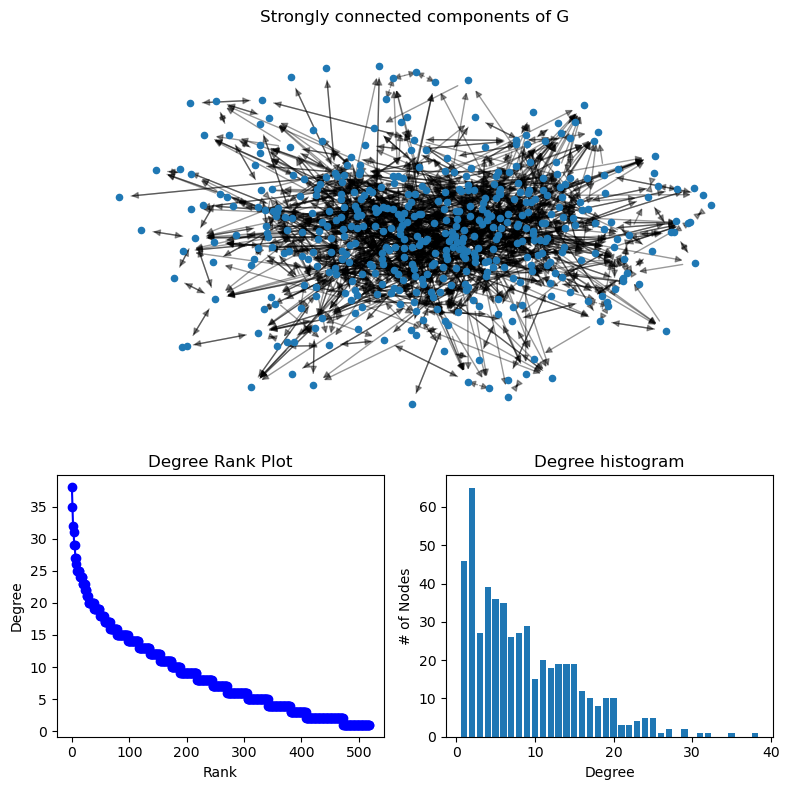

In [94]:
# Degree distribution
import matplotlib.pyplot as plt
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(nx.strongly_connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Strongly connected components of G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()


# Community Analysis

In [97]:
# Run community detection algorithms, add info to graph and export to gephi for visualization
import networkx.algorithms.community as nxc

# Greedy Modularity
greedy_communities = nxc.greedy_modularity_communities(G, weight='weight')
print(len(greedy_communities))

# add community info to node attributes
i = 0
greedy_communities_dict = dict.fromkeys(G.nodes)
for community in greedy_communities:
    for player in community:
        greedy_communities_dict[player] = i
    i += 1

nx.set_node_attributes(G, greedy_communities_dict, "greedy_community")

# output a gephi file for ez visualization
nx.write_gexf(G, 'defense-positive.gexf')


24


In [98]:
# Display stat distributions and other relevant stuff to identify trends within and between communities
